## 1. Importing needed libraries

In [115]:
import librosa
import librosa.display


import keras
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping


import random
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

import fnmatch
import os
import sys


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [110]:
plt.rcParams['figure.figsize'] = [15, 10]  # Make output graphs larger in Jupyter Notebook

<hr>

#### GPU activation for Nvidia GPUs only

In [2]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
# Check that there is an output
from keras import backend as k
k.tensorflow_backend._get_available_gpus()

[]

<hr>

## 2. Data Preparation

In [4]:
data = pd.read_csv('data/metadata.csv')
data.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [5]:
print("The original data containes {0} audio files.".format(data.shape[0]))

# Filter data less than 3 seconds 
dataorg = data[['slice_file_name', 'fold' ,'classID', 'class']]
data3s = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]

print("The data we will work with containes {0} audio files of 3 seconds length.".format(data3s.shape[0]))

data3s.head(10)

The original data containes 8732 audio files.
The data we will work with containes 7468 audio files of 3 seconds length.


,slice_file_name,fold,classID,class
1,100263-2-0-117.wav,5,2,children_playing
2,100263-2-0-121.wav,5,2,children_playing
3,100263-2-0-126.wav,5,2,children_playing
4,100263-2-0-137.wav,5,2,children_playing
5,100263-2-0-143.wav,5,2,children_playing
6,100263-2-0-161.wav,5,2,children_playing
7,100263-2-0-3.wav,5,2,children_playing
8,100263-2-0-36.wav,5,2,children_playing
14,100652-3-0-0.wav,2,3,dog_bark
15,100652-3-0-1.wav,2,3,dog_bark


Different Classes are:
0. air_conditioner  
1. car_horn  
2. children_playing  
3. dog_bark  
4. drilling  
5. engine_idling
6. gun_shot
7. jackhammer
8. siren
9. street_music

Iterate over all samples in _valid_.
For every sample, construct the (128,128) spectrogram

In [6]:
data3s['path'] = 'fold' + data3s['fold'].astype('str') + '/' + data3s['slice_file_name'].astype('str')

In [7]:
dataset = []

for row in data3s.itertuples():
    y, sr = librosa.load('data/UrbanSound8K/' + row.path, duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    dataset.append( (ps, row.classID) )

In [15]:
random.shuffle(dataset)
#X_train, X_test, y_train, y_test = train_test_split(dataset, test_size = .2)

train = dataset[:7000]
test = dataset[7000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))



In [31]:
model = keras.models.Sequential()
input_shape=(128, 128, 1)



# model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=input_shape))    
# model.add(Dropout(0.2))

# model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
# model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
# model.add(Dropout(0.5))

# model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
# model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
# model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
# model.add(Dropout(0.5))    

# model.add(Conv2D(192, (3, 3), padding = 'same'))
# model.add(Activation('relu'))
# model.add(Conv2D(192, (1, 1),padding='valid'))
# model.add(Activation('relu'))
# model.add(Conv2D(10, (1, 1), padding='valid'))

# model.add(GlobalAveragePooling2D())


model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [32]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

Train on 7000 samples, validate on 467 samples
Epoch 1/80
7000/7000 [==============================] - 64s 9ms/step - loss: 3.1472 - acc: 0.1744 - val_loss: 2.2197 - val_acc: 0.2719
Epoch 2/80
7000/7000 [==============================] - 62s 9ms/step - loss: 2.2972 - acc: 0.2214 - val_loss: 2.1813 - val_acc: 0.2805
Epoch 3/80
7000/7000 [==============================] - 63s 9ms/step - loss: 2.1687 - acc: 0.2643 - val_loss: 2.1063 - val_acc: 0.3233
Epoch 4/80
7000/7000 [==============================] - 65s 9ms/step - loss: 2.0756 - acc: 0.2973 - val_loss: 1.9789 - val_acc: 0.4047
Epoch 5/80
7000/7000 [==============================] - 62s 9ms/step - loss: 1.9899 - acc: 0.3291 - val_loss: 1.8567 - val_acc: 0.3854
Epoch 6/80
7000/7000 [==============================] - 63s 9ms/step - loss: 1.8871 - acc: 0.3426 - val_loss: 1.7750 - val_acc: 0.3597
Epoch 7/80
7000/7000 [==============================] - 64s 9ms/step - loss: 1.8010 - acc: 0.3650 - val_loss: 1.7071 - val_acc: 0.3897
Epoch 8/

Epoch 61/80
7000/7000 [==============================] - 63s 9ms/step - loss: 0.4517 - acc: 0.8514 - val_loss: 0.6269 - val_acc: 0.8094
Epoch 62/80
7000/7000 [==============================] - 63s 9ms/step - loss: 0.4530 - acc: 0.8486 - val_loss: 0.6073 - val_acc: 0.8201
Epoch 63/80
7000/7000 [==============================] - 63s 9ms/step - loss: 0.4285 - acc: 0.8631 - val_loss: 0.5561 - val_acc: 0.8266
Epoch 64/80
7000/7000 [==============================] - 61s 9ms/step - loss: 0.4259 - acc: 0.8614 - val_loss: 0.5722 - val_acc: 0.8287
Epoch 65/80
7000/7000 [==============================] - 63s 9ms/step - loss: 0.4447 - acc: 0.8583 - val_loss: 0.6489 - val_acc: 0.8116
Epoch 66/80
7000/7000 [==============================] - 62s 9ms/step - loss: 0.4347 - acc: 0.8541 - val_loss: 0.7174 - val_acc: 0.8287
Epoch 67/80
7000/7000 [==============================] - 62s 9ms/step - loss: 0.4380 - acc: 0.8597 - val_loss: 0.6716 - val_acc: 0.8030
Epoch 68/80
7000/7000 [=========================

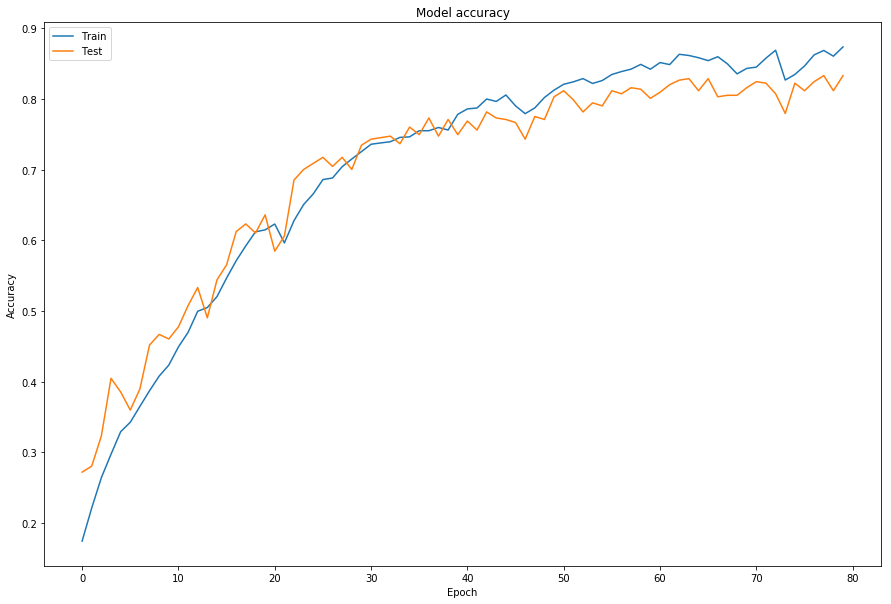

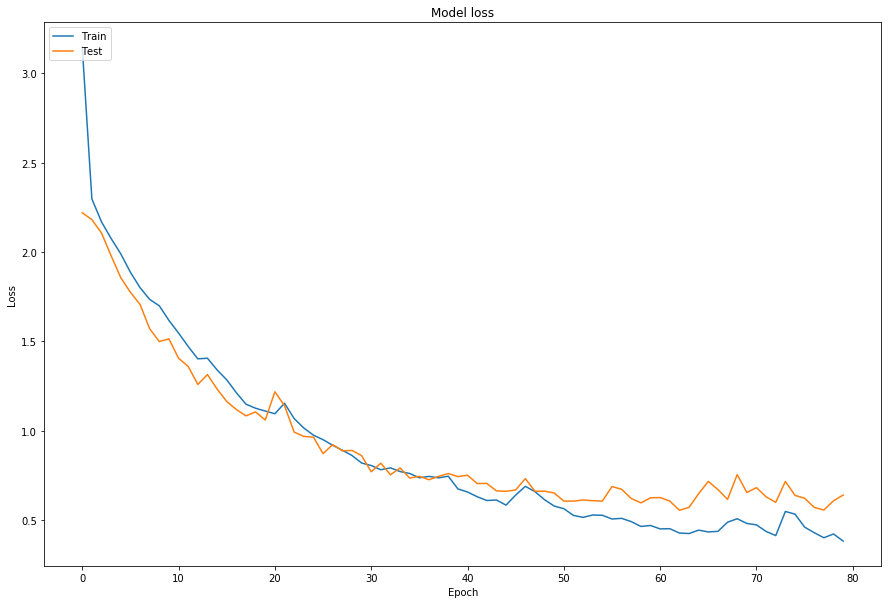

Test loss: 1.2244046683995575
Test accuracy: 0.5952890787185897


In [34]:
best_model = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss')

history = model.fit(
        x=X_train, 
        y=y_train,
        epochs=80,
        batch_size=500,
        validation_data= (X_test, y_test),
        callbacks=[best_model] )

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [116]:
best_model = load_model('best_model.hdf5')

In [97]:
!rm data/myAudioFiles/.DS_Store

In [117]:
path = 'data/myAudioFiles/'

for audio_file in sorted (os.listdir(path)):
    y, sr = librosa.load(path + audio_file, duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)

    k = np.array(ps) #seven
    y = k.reshape(1, 128, 128, 1)
    # predict
    print('File \t{0} \tpredicted as class {1} \t{2}'.format(audio_file, model.predict_classes(y), 
          model.predict_classes(y)[0] == int(audio_file[0]))) # predict class

#     plt.rcParams['figure.figsize'] = [3, 2]  
#     plt.plot(np.arange(10), model.predict(y).ravel())  # prediction likelihoods
#     plt.show()
    



NoBackendError: 

In [119]:
X_train.shape

(7000, 128, 128, 1)